# Relevancy prediction of news articles using neural networks

#### Izzy Stewart, Artificial intelligence, Coursework 2

In this project I am using a variety of techniques to find the best model to predict the 'relevance' of a news article to the US economy. I wanted to use this project to further explore my interest in natural language processing whilst developing my skills using some of the more advanced capabilities of the Keras platform. The dataset I am using 'Economic News Article Tone and Relevance' is from '[figure eight](https://www.figure-eight.com/data-for-everyone/)' where contributors have read snippets of news articles and noted if the article was relevant to the US economy. The dataset has two columns containing the article headline and the snippet from the body of the text. As my previous project involved predicting the sentiment of tweets, I thought it would be interesting using the text variable as a predictor, which is alot more text heavy. In addition, I was also keen to test if combining the headline and text variables would improve the models accuracy compared to just looking at the text variable. My instinct was that it would, as a headline often gives a good indication of the content of the article. 

#### The problem type
The analysis problem I am using is defined as a binary single label classification problem. This means there are two classes (relevant and not relevant) and each observation (news article) can only belong to one of those classes.  

#### Hypothesis
My hypothesis for this project is that the relevance of the news articles (with respect to the US economy) in the given dataset can be predicted with an accuracy rate better than 50%. Once this hypothesis is acheived I want to tune optimize the model and its hyper-parameter settings in order to improve the accuracy rate.

#### Success metric 
Accuracy rate of the model on the test data.

#### Evaluation protocol
A hold out validation set taken from the training data

The dataset provides many more variables other than relevance, article headline and text, but for the purpose of this project I am going to ignore them. It is worth remembering that the 'relevance' of each article was decided by contributors to the dataset. This means, in a sense, the neural network I build will be learning to predict the contributors opinion of the articles relevance, which might not be everyones view of its relevance. However I think this still provides an interesting platform for analysis.

## Preprocessing

Before using this dataset it was necessary for me to check the data was clean enough for analysis. This involved checking for missing or empty values in the features and outcome variable. Doing this highlighted an extra value in the 'relevance' column 'not sure.' As there were not enough of this value to make it predictive, I removed these. 
<br>
<br>
As this data was taken from a source outside of Keras, I had to apply various transformations to get it ready to use with the models. The first step was to change all letters in the input variables to lowercase. This is as Keras is case sensitive and will treat the same words with different cases differently. The next step was to apply functions to the feature and output variables to transform into tensors and from text to digits.
<br>
<br>
In the cells below I run through the above steps and provide details of what I have done at each stage. Many of the functions I have created make use of the keras preprocessing module, which I found really useful. To keep the report as clean and consise as possible, I have kept most of the preprocessing code in a seperate file, preprocdata.py.

#### Import and read in data

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [10]:
# Import keras and check version
import keras
keras.__version__

'2.2.4'

In [0]:
# Import general modules
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
from collections import Counter
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.datasets import make_classification

# Import Keras modules 
from keras.preprocessing.text import hashing_trick
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from keras.utils.np_utils import to_categorical
from keras import models
from keras.models import Model
from keras import Input
from keras import layers
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.layers import Embedding
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.wrappers.scikit_learn import KerasClassifier

In [0]:
# Importing created file for preprocessing
import preprocdata as pre

In [0]:
# Read in columns needed from dataset using preprocessing module
df = pre.read_csv('gdrive/My Drive/Colab Notebooks/AI_C2_NEWS/News_articles/raw_data_copy.csv', 'relevance', 'headline', 'text')

In [14]:
# To check, look at the first line of data
df.head(1)

,relevance,headline,text
0,yes,Yields on CDs Fell in the Latest Week,NEW YORK -- Yields on most certificates of dep...


#### Data cleaning

Looking first at the outcome 'relevance' class label, I remove the 'not sure' values as there are not enough to make them predictive. One thing that is worth considering is the class imbalance between the 'no' and 'yes' values. The larger number of 'no' values, this may effect the models performance, where it will learn to predict more no's than yes's. This could be tackled by using resampling methods such as SMOTE, upsampling and downsampling. Due to the time-restrictions of this project I unfortunately could not investigate this further. 

In [15]:
# Check values of outcome variable
print(df['relevance'].unique())

# Count each value
print(df['relevance'].value_counts())

# Removing 'not sure' observations as not enough to predict
df = df[df['relevance'] != 'not sure']

['yes' 'not sure' 'no']
no          2472
yes         1420
not sure       9
Name: relevance, dtype: int64


In [16]:
# Check for empty or NAN values - none found
print(df[df['headline'] == ''].index)
print(df[df['text'] == ''].index)
print(df.isnull().values.any())

Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
False


In [17]:
# Change to lowercase
df['headline'] = df['headline'].str.lower()
df['text'] = df['text'].str.lower()

# Check result
df.head(1)

,relevance,headline,text
0,yes,yields on cds fell in the latest week,new york -- yields on most certificates of dep...


#### Vectorise outcome variable

Both the input data and class labels need to be in the correct format to feed into a neural network. For the network type I plan to use (binary, single label class) I need both datasets in tensor format. In the cells below you can see the steps taken to transform the 'relevance' class labels into this format.

In [0]:
# Apply text to num function from 'preprocdata' module to create Y vector
relevance = pre.text_to_num(df)

In [19]:
# Check result. One = yes, Zero = no
relevance

array([1, 1, 1, ..., 0, 0, 0])

#### Vectorise predictor variables

Using the built in Keras preproccessing features I was able to transform the predictor variables into the correct tensor format. This first step involved tokenising the data using the most frequent words from the set maximum number of words. To decide the maxium number of words I took a fraction of the total number of unique words in each predictor. The next step was to use the 'pad-sequences' function to cut each input at the 'maximum length' set (and pad any inputs that are shorter than this length with zeros).

In [0]:
# Defining the maximum number of words used for each predictor.
text_max_words = 4500
headline_max_words = 800

# Defining the maximum length for each input value (headline and text).
text_max_len = 100
headline_max_len = 15

In [0]:
# Setting input variables
text_input = df['text']
headline_input = df['headline']

In [0]:
# Applying the 'create_input_vector' function from the preprocdata module

# Returns the text tensor and word_index
text, text_index = pre.create_input_vectors(text_max_words, 
                                        text_input, 
                                        text_max_len)

# Returns the headline tensor and word_index
headline, headline_index = pre.create_input_vectors(headline_max_words, 
                                                headline_input, 
                                                headline_max_len)

In [23]:
# Used to help define max_word variables above
print(len(text_index))
print(len(headline_index))

36080
6755


#### Shuffle and split data
To insure the data is not ordered in a way that is predictive, I apply shuffling both the predictor variables and class variable. After that I use the sklearn package to split the data into training, test and validation sets. I chose to split the data 80 / 20 training and testing and then 80 / 20 again training and validation sets. This was taken from best practice suggestions where the need for the training set to be as large as possible for improving the model is highlighted. In this process I also save the full training predictor and class variables (before validation splitting). This is to use later when I apply cross validation using the Grid Search method.

In [0]:
# Shuffle datasets using function in preprocdata module
text_data, headline_data, output_data = pre.shuffle_data(text, 
                                                     headline, 
                                                     relevance)

In [0]:
# Split training and test for text data
text_train, text_test, output_train, output_test = train_test_split(text_data,
                                                                    output_data,
                                                                    test_size=0.2,
                                                                    random_state=42)

In [0]:
# Leave a copy of the full training set to use with cross validation later
train_text_full = text_train
train_output_full = output_train

In [0]:
# Split training and validation for text data
text_train, text_val, output_train, output_val = train_test_split(text_train, 
                                                                  output_train, 
                                                                  test_size=0.2, 
                                                                  random_state=42)

In [0]:
# Split training and test for headline data
headline_train, headline_test, output_train, output_test = train_test_split(headline_data,
                                                                            output_data,
                                                                            test_size=0.2,
                                                                            random_state=42)

In [0]:
# Split training and validation for headline data
headline_train, headline_val, output_train, output_val = train_test_split(headline_train, 
                                                                          output_train, 
                                                                          test_size=0.2, 
                                                                          random_state=42)

## Part 1 Find the best model for predicting relevance using the text variable. 

For this project my analysis is split into two parts. In the first section I try to predict relevance with just the text variable. This involves running the universal workflow using a series of sequential models.
<br>
<br>
The steps I have taken are:
<br>
#### Acheive a baseline

- Find a model that predicts relevance with an accuaracy above 50%

#### Scale up

- Compare the performance of built-in word embeddings to pre-trained word embeddings
- Add a dense hidden layer
- Add a LSTM hidden layer
- Add a Convnet hidden layer

#### Model functions

The functions I have created below are used throught the project to build and fit various deep learning models. The first function allows you to set the number of neurons per hidden layer and the type of layer (dense, lstm or convnet) when calling. This is useful later on when I test these parameters. I have left the optimizer as rmsprop and the loss as binary crossentropy (as suggested for a binary single label problem).

In [0]:
# Function to build sequential model
def build_model(max_words, embed_size, maxlen, neuron_num, layer_type):
    # Defining model as sequential type
    model = Sequential()
    # Adding embedding layer
    model.add(Embedding(max_words, embed_size, input_length=maxlen))
    # Hidden layer added as stated when calling the model
    if layer_type == 'dense':
        model.add(Flatten())
        print("model with dense hidden layers")
        model.add(layers.Dense(neuron_num, activation = 'relu'))
    elif layer_type == 'lstm':
        print("model with lstm hidden layers")
        model.add(LSTM(neuron_num))
    elif layer_type == 'conv':
        print("model with conv hidden layers")
        model.add(layers.Conv1D(neuron_num, 7, activation='relu'))
        model.add(layers.GlobalMaxPooling1D())
    elif layer_type == 'none':
        model.add(Flatten())
        print("model with no hidden layers")
    # Single output using the sigmoid function
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
    # Return model
    return model

In [0]:
def model_fit(model,x,y,x_val,y_val,epoch,batch,patience):
    # Setting the metric variables to 'global' so I can use outside the program.
    global val_loss, loss, acc, val_acc
    # Setting early stopping
    callbacks_list = [
        keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience)
    ]
    # Printing line to show reader program has started.
    print("In progress: Model fitting to train and testing on validation.")
    # Fitting model and assigning to 'history' variable.
    history = model.fit(x,y, epochs = epoch,batch_size = batch,
                        callbacks=callbacks_list,
                        validation_data = (x_val, y_val),
                        # Set to zero to avoid too much text outputted.
                        verbose = 0)
    # Printing line to show program has finished.
    print("Finished. Model trained, and tested on the validation set.")
    # Collecting loss and accuracy metrics in list format.
    val_loss = history.history['val_loss']
    loss = history.history['loss']
    acc = history.history['acc']
    val_acc = history.history['val_acc']

### Acheive a baseline

The first step is to develop a model that underfits but has statistical power. Using the two functions above I trained a model using only the built-in embeddings layer. This learns embeddings from the training set and uses these to predict the class outcome. I have given the embeddings layer eight dimensions, as the dataset is quite small. I then retrain a new model with the same parameters and the optimum epoch number to evaluate on the test set. It is important to do this on a new model to acheive an unbiased result. Runnning the model on the test results gives an accuracy of 77%, which gives it statistical power.

In [0]:
# Apply build_model function with set parameters.
model = build_model(4501, 8, 100, 0, 'none')

# Fit model using model_fit function
model_fit(model, text_train, output_train, text_val, output_val, 20, 32, 2)
# Running argmin to see where overfitting begins.
print("Overfitting begins at ", np.argmin(val_loss) + 1, " epochs.")

model with no hidden layers
In progress: Model fitting to train and testing on validation.
Finished. Model trained, and tested on the validation set.
Overfitting begins at  9  epochs.


In [0]:
# Saving these metrics for reporting later 
val_loss_b = val_loss
val_acc_b = val_acc

In [0]:
# Building new model on optimum number of epochs.
model = build_model(4501,8,100,0,'none')
model_fit(model, text_train, output_train, text_val, output_val, 
          9, 32, 2)
# Returns the loss value & metrics values for the model in test mode.
test_results = model.evaluate(text_test, output_test)
test_results

model with no hidden layers
In progress: Model fitting to train and testing on validation.
Finished. Model trained, and tested on the validation set.
779/779 [==============================] - 0s 56us/step


[0.48990238845271844, 0.7753530169941188]

### Scaling up

After acheiving a baseline model with statistical power, the next step is to experiment with different hyper-parameters to scale up the model, reaching the point where is overfits the data.

#### Using glove embedding

The baseline model uses a word embedding that has been created whilst building the model and uses the text data in the training set to creat the embeddings. In this section I test using a pre-trained embedding from GloVe. GloVe have a range of embeddings taken from large texts such as wikipedia. The embedding I have used has 100 dimension and contains 400000 word vectors. Compared to the built-in embedding it will contain alot more complex word patterns but will not have learnt the patterns contained in this dataset, making it an interesting test.

In [0]:
# Adapted from 'Deep learning with Python'
def embed_index(glove_dir):
    embeddings_index = {}
    f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    return embeddings_index

In [0]:
# Adapted from 'Deep learning with Python'
def embed_matrix(max_words, embedding_dim, word_index, embeddings_index):
    embedding_matrix = np.zeros((max_words, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if i < max_words:
            if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [0]:
# Directory containing the glove embedding
glove_dir = 'gdrive/My Drive/Colab Notebooks/AI_C2_NEWS/News_articles/glove'
# Set dimension size for input
embedding_dim = 100

# Calling above functions to create embedding matrix
embeddings_index = embed_index(glove_dir)
embedding_matrix = embed_matrix(text_max_words, embedding_dim, 
                                text_index, embeddings_index)

In [0]:
# Building model
model = build_model(text_max_words, embedding_dim, 100, 0, 'none')

model with no hidden layers


In [0]:
# Set weights to new embedding matrix
model.layers[0].set_weights([embedding_matrix])
# Freeze weights in training (as they need to stay as set by pre-training)
model.layers[0].trainable = False

In [0]:
# Fit model with set parameters
model_fit(model, text_train, output_train, text_val, output_val, 
          20, 32, 2)

# Save loss and accuracy metrics
val_loss_g = val_loss
val_acc_g = val_acc
# Running argmin to see where overfitting begins.
print("Overfitting begins at ", np.argmin(val_loss) + 1, " epochs.")

In progress: Model fitting to train and testing on validation.
Finished. Model trained, and tested on the validation set.
Overfitting begins at  1  epochs.


In [0]:
# Building new model on optimum number of epochs.
model = build_model(text_max_words, embedding_dim, 100, 0, 'none')
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model_fit(model, text_train, output_train, text_val, output_val, 1, 32, 2)
# Returns the loss value & metrics values for the model in test mode.
test_results = model.evaluate(text_test, output_test)
test_results

model with no hidden layers
In progress: Model fitting to train and testing on validation.
Finished. Model trained, and tested on the validation set.
779/779 [==============================] - 0s 58us/step


[0.8126797783206455, 0.6675224649278741]

In [0]:
print("GLOVE    | Best loss score: ",val_loss_g[0], "at", np.argmin(val_loss_g) + 1, "epoch")
print("GLOVE    | Best acc score: ",val_acc_g[2], "at", np.argmax(val_acc_g) + 1, "epoch")
print("BUILT-IN | Best loss score: ",val_loss_b[8], "at", np.argmin(val_loss_b) + 1, "epoch")
print("BUILT-IN | Best acc score: ",val_acc_b[9], "at", np.argmax(val_acc_b) + 1, "epoch")

GLOVE    | Best loss score:  0.6460598420178335 at 1 epoch
GLOVE    | Best acc score:  0.6886035317785284 at 3 epoch
BUILT-IN | Best loss score:  0.4861553030545983 at 9 epoch
BUILT-IN | Best acc score:  0.7833065812507373 at 10 epoch


Looking at the results the built-in embeddings model performs best on the validation data. This could mean that the text contains patterns that are unique to this dataset and do not fit the pre-trained, more general patterns. Moving forward I will use the built-in embeddings on all future models in this project. 

#### LSTM, CONV and DENSE layers

I will now look at increase the size of the model using added hidden layers. I want to analyse the models performance by adding a dense, LSTM and 1D Convnet layer in three seperate tests. As with the previous tests, adding a dense layer treats the words in the text as non-sequential, where each input is flattened after the embedding is applied. Whereas the LSTM layers retains information from past inputs allowing for the sequence of the words to be predictive. Equally the 1D Convnet can also work with sequences, where the convolutional windows can looks at multiple feature vectors to find patterns. The Convnet models contain a 1 dimension Conv layer, a  pooling layer that simplifies the information from the previous layer and a flatten layer so as the input can feed into the final dense classification layer.

In [0]:
# Creating a list 'neuron_num' to define the number of neurons per layer to test training each model on.
neuron_num = [5, 10, 20, 40]

# Function created to loop through the neuron_num list and train a new model on each item in that list.
def test_layer_size(neuron_num, layer_type):
    # Setting global variables to use outside the function.
    global val_loss_list, train_loss_list, val_acc_list, train_acc_list
    val_loss_list = []
    train_loss_list = []
    val_acc_list = []
    train_acc_list = []
    # For loop to build i number of models using i number of neurons per layer.
    for i in range(len(neuron_num)):
        # Printing line to show which neuron number is being used in each model train.
        print("Training with layer size: ", neuron_num[i])
        mod = build_model(text_max_words, 8, 100, neuron_num[i], layer_type)
        # Fitting model.
        model_fit(mod, text_train, output_train, text_val, output_val, 20, 32, 20)
        # Append loss and accuracy metrics to lists.
        val_loss_list.append(val_loss)
        train_loss_list.append(loss)
        val_acc_list.append(val_acc)
        train_acc_list.append(acc)

In [0]:
test_layer_size(neuron_num, 'dense')
# Assigning metrics to new variables (for reporting later).
train_loss_dense = train_loss_list
val_loss_dense = val_loss_list
val_acc_dense = val_acc_list
train_acc_dense = train_acc_list

Training with layer size:  5
model with dense hidden layers
In progress: Model fitting to train and testing on validation.
Finished. Model trained, and tested on the validation set.
Training with layer size:  10
model with dense hidden layers
In progress: Model fitting to train and testing on validation.
Finished. Model trained, and tested on the validation set.
Training with layer size:  20
model with dense hidden layers
In progress: Model fitting to train and testing on validation.
Finished. Model trained, and tested on the validation set.
Training with layer size:  40
model with dense hidden layers
In progress: Model fitting to train and testing on validation.
Finished. Model trained, and tested on the validation set.


In [0]:
test_layer_size(neuron_num, 'lstm')
# Assigning metrics to new variables (for reporting later).
train_loss_lstm = train_loss_list
val_loss_lstm = val_loss_list
val_acc_lstm = val_acc_list
train_acc_lstm = train_acc_list

Training with layer size:  5
In progress: Model fitting to train and testing on validation.
Finished. Model trained, and tested on the validation set.
Training with layer size:  10
In progress: Model fitting to train and testing on validation.
Finished. Model trained, and tested on the validation set.
Training with layer size:  20
In progress: Model fitting to train and testing on validation.
Finished. Model trained, and tested on the validation set.
Training with layer size:  40
In progress: Model fitting to train and testing on validation.
Finished. Model trained, and tested on the validation set.


In [0]:
test_layer_size(neuron_num, 'conv')
# Assigning metrics to new variables (for reporting later).
train_loss_conv = train_loss_list
val_loss_conv = val_loss_list
val_acc_conv = val_acc_list
train_acc_conv = train_acc_list

Training with layer size:  5
In progress: Model fitting to train and testing on validation.
Finished. Model trained, and tested on the validation set.
Training with layer size:  10
In progress: Model fitting to train and testing on validation.
Finished. Model trained, and tested on the validation set.
Training with layer size:  20
In progress: Model fitting to train and testing on validation.
Finished. Model trained, and tested on the validation set.
Training with layer size:  40
In progress: Model fitting to train and testing on validation.
Finished. Model trained, and tested on the validation set.


In [0]:
# Function to plot the validation or training metrics for a set of model paramters.
def plot_models(metrics_list, labels_list, ylabel, title):
    colors = ['b','r','g','y','m']
    epochs = range(1, len(train_loss_list[0]) + 1)
    for i in range(len(metrics_list)):
        plt.plot(epochs, metrics_list[i], colors[i], label=labels_list[i])
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend() 
    plt.show() 

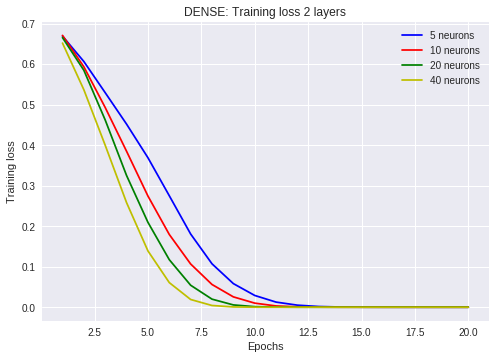

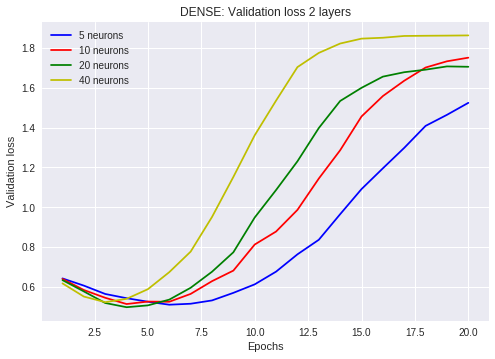

In [0]:
# Plotting the results where there are two hidden layers.
labels_list = ['5 neurons','10 neurons','20 neurons','40 neurons']
plot_models(train_loss_dense, labels_list, "Training loss", "DENSE: Training loss 2 layers")
plot_models(val_loss_dense, labels_list, "Validation loss", "DENSE: Validation loss 2 layers")

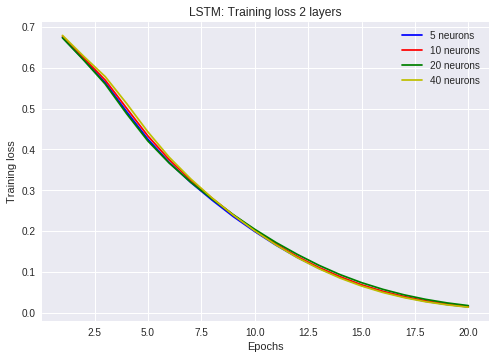

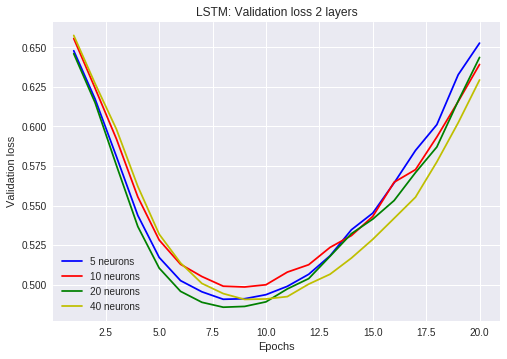

In [0]:
# Plotting the results where there are two hidden layers.
labels_list = ['5 neurons','10 neurons','20 neurons','40 neurons']
plot_models(train_loss_lstm, labels_list, "Training loss", "LSTM: Training loss 2 layers")
plot_models(val_loss_lstm, labels_list, "Validation loss", "LSTM: Validation loss 2 layers")

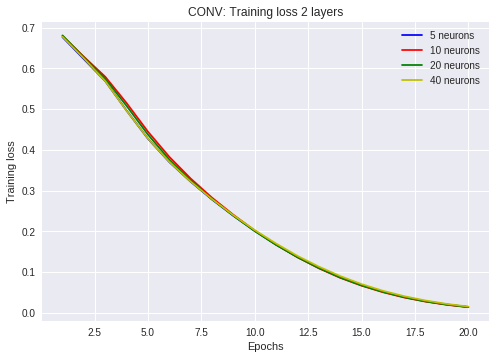

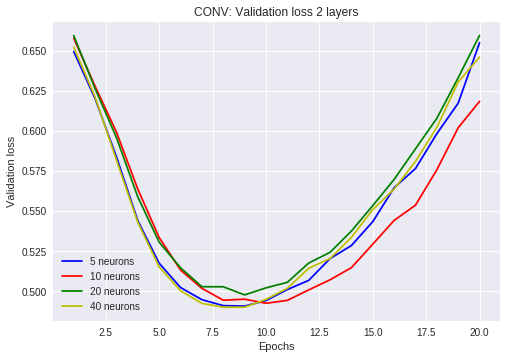

In [0]:
# Plotting the results where there are two hidden layers.
labels_list = ['5 neurons','10 neurons','20 neurons','40 neurons']
plot_models(train_loss_conv, labels_list, "Training loss", "CONV: Training loss 2 layers")
plot_models(val_loss_conv, labels_list, "Validation loss", "CONV: Validation loss 2 layers")

In [72]:
# Building new models on optimum number of epochs + neuron numbers.
model_D = build_model(text_max_words, 8, 100, 20, 'dense')
model_L = build_model(text_max_words, 8, 100, 20, 'lstm')
model_C = build_model(text_max_words, 8, 100, 40, 'conv')

model_fit(model_D, text_train, output_train, text_val, output_val, 4, 32, 2)
test_results_D = model_D.evaluate(text_test, output_test)
print(test_results_D)

model_fit(model_L, text_train, output_train, text_val, output_val, 8, 32, 2)
test_results_L = model_L.evaluate(text_test, output_test)
print(test_results_L)

model_fit(model_C, text_train, output_train, text_val, output_val, 8, 32, 2)
test_results_C = model_C.evaluate(text_test, output_test)
print(test_results_C)

model with dense hidden layers
model with lstm hidden layers
model with conv hidden layers
In progress: Model fitting to train and testing on validation.
Finished. Model trained, and tested on the validation set.
779/779 [==============================] - 0s 62us/step
[0.5103763328896255, 0.7432605903476133]
In progress: Model fitting to train and testing on validation.
Finished. Model trained, and tested on the validation set.
779/779 [==============================] - 2s 3ms/step
[0.5100547326238531, 0.7753530170706332]
In progress: Model fitting to train and testing on validation.
Finished. Model trained, and tested on the validation set.
779/779 [==============================] - 0s 67us/step
[0.4997303739132716, 0.7792041076775233]


In [0]:
print("DENSE    | Best loss score:",val_loss_dense[2][3], "(20 hidden neurons at 4 epochs)")
print("DENSE    | Best acc score:",val_acc_dense[2][6], "(20 hidden nerurons at 7 epochs)")
print("LSTM     | Best loss score:",val_loss_lstm[2][7], "(20 hidden nerurons at 8 epochs)")
print("LSTM     | Best acc score:",val_acc_lstm[2][10], "(20 hidden nerurons at 11 epochs)")
print("CONV     | Best loss score:",val_loss_conv[3][7], "(40 hidden nerurons at 8 epochs)")
print("CONV     | Best acc score:",val_acc_conv[1][17], "(10 hidden nerurons at 17 epochs)")

DENSE    | Best loss score: 0.497295092043869 (20 hidden neurons at 4 epochs)
DENSE    | Best acc score: 0.7704654896622868 (20 hidden nerurons at 7 epochs)
LSTM     | Best loss score: 0.48566462919953163 (20 hidden nerurons at 8 epochs)
LSTM     | Best acc score: 0.7849117176873344 (20 hidden nerurons at 11 epochs)
CONV     | Best loss score: 0.49006880085502735 (40 hidden nerurons at 8 epochs)
CONV     | Best acc score: 0.7817014448141401 (10 hidden nerurons at 17 epochs)


Looking at the results I can see that the LSTM model performs best in both the validation loss and accuracy, with the Convnet coming second. This is not surprising as the LSTM is the most powerful of the three for sequential modelling. 

## Part 2 Testing adding the 'headline' predictor using a multi-input model

In the second part I use a multi-input model to test if adding a second variable ‘headline’ could improve on the best model from part 1. This involves using the functional api model  architecture as opposed to the sequential one, where I treat layers as functions chaining each one to the previous. This code style allows me to input each predictor variable seperately and concatenate them together at the end to make predictions. I was very interested to see if this method could improve on the results of part one. I chose to add the headline variable as the second input, as I felt the shorter 'summing up' of the article could add predictive power along with the larger text variable.

In [0]:
def multi_input(nn1, nn2):
    # Input 1: Text 
    text_input = Input(shape=(100,))
    embedded_text = layers.Embedding(4501, 8, input_length=100)(text_input)
    encoded_text = layers.LSTM(nn1)(embedded_text)
    # Input 2: Headline
    headline_input = Input(shape=(15,))
    embedded_headline = layers.Embedding(801, 8, input_length=15)(headline_input)
    encoded_headline = layers.LSTM(nn2)(embedded_headline)
    # Merge models
    merge = layers.Concatenate(axis=-1)([encoded_text, encoded_headline])
    # Output layer
    output = Dense(1, activation='sigmoid')(merge)
    # Model
    model = Model(inputs=[text_input, headline_input], outputs=output)
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    return model

In [0]:
def model_fit2(mod, text_train, headline_train, text_val, headline_val, output_val, epoch, batch):
  # Build model using above function
  history = model.fit([text_train, headline_train], 
                      output_train,
                      epochs=epoch,
                      batch_size=batch,
                      validation_data=[[text_val, headline_val], output_val],
                      verbose=0
                     )

In [0]:
def model_fit(nn1,nn2,text_train, 
              headline_train, text_val, headline_val, output_val, epoch, batch):
    # Build model using above function
    global model
    model = multi_input(nn1, nn2)
    history = model.fit([text_train, headline_train], 
                        output_train,
                        epochs=epoch,
                        batch_size=batch,
                        validation_data=[[text_val, headline_val], output_val],
                        verbose=0)

In [0]:
# Creating a list 'neuron_num' to define the number of neurons per layer to test training each model on.
nn1 = [20, 32, 45]
nn2 = [5, 10, 20] # Using a smaller number of neurons for the shorter headline text
        
        
def test_nn(nn1,nn2):
    global val_loss_list, train_loss_list, val_acc_list, train_acc_list
    val_loss_list = []
    train_loss_list = []
    val_acc_list = []
    train_acc_list = []
    # For loop to build i number of models using i number of neurons per layer.
    for i in range(len(nn1)):
        # Printing line to show which neuron number is being used in each model train.
        print("Training with layer size: ", nn1[i], "for input 1 and", nn2[i], "for input 2")
        model = multi_input(nn1[i], nn2[i])
        history = model.fit([text_train, headline_train], 
                        output_train,
                        epochs=20,
                        batch_size=100,
                        validation_data=[[text_val, headline_val], output_val],
                        # Set to zero to avoid too much text outputted.
                        verbose = 0
                       )
    val_loss = history.history['val_loss']
    loss = history.history['loss']
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    # Append loss and accuracy metrics to lists.
    val_loss_list.append(val_loss)
    train_loss_list.append(loss)
    val_acc_list.append(val_acc)
    train_acc_list.append(acc)

In [51]:
test_nn(nn1,nn2)
# Assigning metrics to new variables (for reporting later).
train_loss = train_loss_list
val_loss = val_loss_list
val_acc = val_acc_list
train_acc = train_acc_list

Training with layer size:  20 for input 1 and 5 for input 2
Training with layer size:  32 for input 1 and 10 for input 2
Training with layer size:  45 for input 1 and 20 for input 2


In [0]:
# Function to plot the validation or training metrics for a set of model paramters.
def plot_models(metrics_list, labels_list, ylabel, title):
    colors = ['b','r','g','y','m']
    epochs = range(1, len(train_loss_list[0]) + 1)
    for i in range(len(metrics_list)):
        plt.plot(epochs, metrics_list[i], colors[i], label=labels_list[i])
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend() 
    plt.show() 

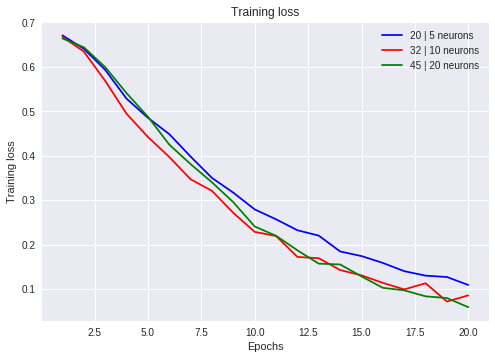

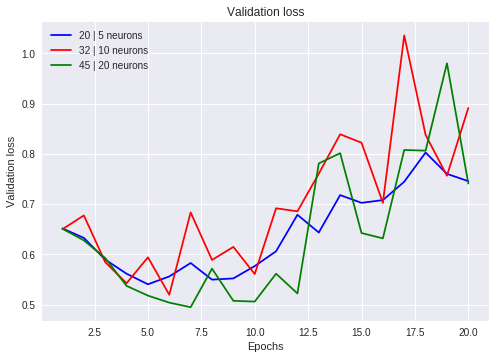

In [53]:
# Plotting the results where there are two hidden layers.
labels_list = ['20 | 5 neurons','32 | 10 neurons','45 | 20 neurons']
plot_models(train_loss, labels_list, "Training loss", "Training loss")
plot_models(val_loss, labels_list, "Validation loss", "Validation loss")

In [0]:
# Building new models on optimum number of epochs + neuron numbers.
model = multi_input(45, 20)
model_fit2(model,text_train, headline_train, text_val, headline_val, output_val, 20, 100)

test_results_M = model.evaluate(text_test, output_test)
print(test_results_M)

In [89]:
print("MULTI-INPUT    | Best loss score: 0.49467346804099904 (45 & 20 hidden neurons at 6 epochs)")
print("MULTI-INPUT    | Best acc score: 0.7913322618072718 (45 & 20 hidden neurons at 7 epochs)")

MULTI-INPUT    | Best loss score: 0.49467346804099904 (45 & 20 hidden neurons at 6 epochs)
MULTI-INPUT    | Best acc score: 0.7913322618072718 (45 & 20 hidden neurons at 7 epochs)


It is interesting to see no clear improvement comparing validation loss and accuracy to that of the best performing sequential model. Looking at the validation loss plot, the results are very changable as the epochs increase. 

### Adding a dropout rate

In [0]:
def multi_input(nn1, nn2):
    # Input 1: Text 
    text_input = Input(shape=(100,))
    embedded_text = layers.Embedding(4501, 8, input_length=100)(text_input)
    encoded_text = layers.LSTM(nn1)(embedded_text)
    dropout_text = Dropout(0.5)(encoded_text)
    # Input 2: Headline
    headline_input = Input(shape=(15,))
    embedded_headline = layers.Embedding(801, 8, input_length=15)(headline_input)
    encoded_headline = layers.LSTM(nn2)(embedded_headline)
    dropout_headline = Dropout(0.5)(encoded_headline)
    # Merge models
    merge = layers.Concatenate(axis=-1)([dropout_text, dropout_headline])
    # Output layer
    output = Dense(1, activation='sigmoid')(merge)
    # Model
    model = Model(inputs=[text_input, headline_input], outputs=output)
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    return model

In [35]:
test_nn(nn1,nn2)
# Assigning metrics to new variables (for reporting later).
train_loss = train_loss_list
val_loss = val_loss_list
val_acc = val_acc_list
train_acc = train_acc_list

Training with layer size:  20 for input 1 and 5 for input 2
Training with layer size:  32 for input 1 and 10 for input 2
Training with layer size:  45 for input 1 and 20 for input 2


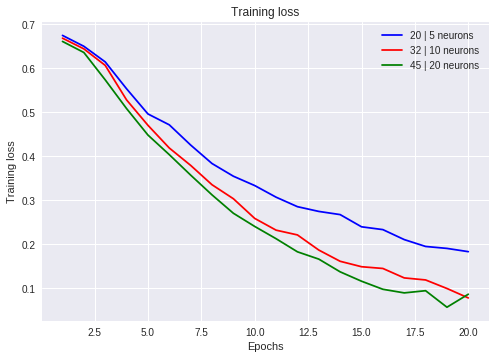

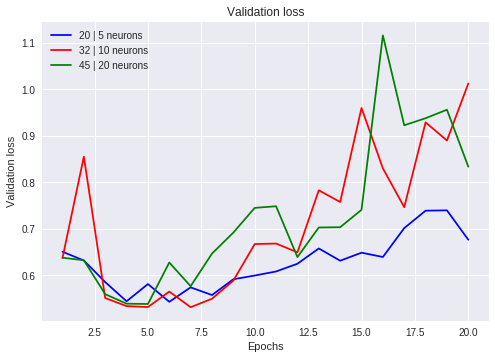

In [37]:
# Plotting the results where there are two hidden layers.
labels_list = ['20 | 5 neurons','32 | 10 neurons','45 | 20 neurons']
plot_models(train_loss, labels_list, "Training loss", "Training loss")
plot_models(val_loss, labels_list, "Validation loss", "Validation loss")

In [44]:
print("MULTI-INPUT    | Best loss score: 0.5310970901677543 (32 & 10 hidden neurons at 6 epochs)")
print("MULTI-INPUT    | Best acc score: 0.7768860369394526 (20 & 5 hidden neurons at 7 epochs)")

MULTI-INPUT    | Best loss score: 0.5310970901677543 (32 & 10 hidden neurons at 6 epochs)
MULTI-INPUT    | Best acc score: 0.7768860369394526 (20 & 5 hidden neurons at 7 epochs)


## Report results

| Test type | Description | Validation loss | Test accuracy |
| --- | --- | --- | --- |
| Baseline | Built-in embedding with no hidden layers | 0.486 | 0.775 |
| Scaling up | GLOVE with no hidden layers | 0.646 | 0.668 |
| Scaling up | DENSE hidden layers | 0.497 | 0.743 |
| Scaling up | LSTM hidden layers | 0.486 | 0.775 |
| Scaling up | CONV hidden layers | 0.490 | 0.779 |
| Scaling up | Multi-input LSTM model | 0.495 | 0.743 |
| Regulise and tune | Multi-input LSTM model with dropout | 0.531 | - |

## Conclusion

Looking at the results I can see that the best test accuaracy is acheived from adding the ConvNet hidden layer. It is interesting as it did not perform as well on the validation set. Comparing to the LSTM model (that performed much better on the validation set) this could mean that the more complex LSTM model learnt too much from the validation data. 
<br>
<br>

Another interesting finding is how poorly the GLOVE embedding performed on comparison to the other models. As mentioned earlier this could be due to the fact that the patterns in the text variable are unique to this dataset and therefor the built-in embedding performed best. It may also be due to the fact that as this dataset is quite smal, the bigger, more complex vectors found in the GLOVE embedding could not be picked up.
<br>
<br>

If I had more time, I would apply further regulisation and tuning methods to the multi-input model, such as adjusting the learning rate and testing more dropout rates. As this model is much more complex I feel it could be improved as it is likely overfitting. I would also be keen to apply the grid-search method to have a more thorough way to optimise the hyper-parameters. I found using google colab an effective way to run models at a faster pace than locally and will continue to use this tool on other projects.